# Сравнение операторов

Идея создания этого блокнота в том, чтобы сравнить символы операторов, которые получаются в результате применения явных формул, с тем, что можно можно получить с использованием приближённых формул.

Сравнение будет на первых порах графическим, далее, вероятно, можно посмотреть и саму ошибку.

Опцион выбран самым обычным

In [1]:
import numpy as np
from numpy import log, sqrt
from numpy import exp, linspace, fft, array, arange, pi
import matplotlib.pyplot as plt

In [2]:
import time
# для измерения времени
class Profiler(object):
    def __enter__(self):
        self._startTime = time.time()
         
    def __exit__(self, type, value, traceback):
        print("Elapsed time: {:.3f} sec".format(time.time() - self._startTime))

Параметры контракта down-and-out put

In [3]:
# model parameters - we are going to evaluate a barrier put
T = 1
H_original = 90.0 # limit
K_original = 100.0 # strike
r_premia = 10 # annual interest rate
r = log(r_premia/100 + 1)
V0 = 0.316227766

In [4]:
# Определим функцию выплат:
def G(y, barrier, strike):
    """payoff_function for a given option type (down-and-out put there)"""
    if (barrier <= y) and (y <= strike):
        return K_original - H_original*exp(y)
    else:
        return 0

Характеристическая экспонента процесса Б-Ш
$$\psi(\xi) = \frac{{\color{green}{\sigma}}^2}{2} \xi^2 - i{\color{green}{\gamma}}\xi$$

In [5]:
sigma = V0
gamma = r - 0.5 * sigma**2 # Black-Scholes parameter, from a no-arbitrage condition

def psi(xi):
    return (sigma**2/2) * xi * xi - 1j*gamma*xi

Подготавливаем дискретизацию, задаём шкалу по переменной, связанной с ценой, производим замены
$$ y = ln(S)$$
$$ K = ln(K), H = ln(H) $$

Укладываем $M$ точек между $L \cdot ln(1/2)$  и $ L \cdot ln(2) $

In [8]:
# constants in log scale for price, by Zanette
M = 2**14  # number of points in price grid
L = 2  # scaling coefficient
y_min = L * log(0.5)
y_max = L * log(2.0)
d = (y_max - y_min) / M  # discretization step
K = log(K_original/H_original)
H = log(H_original/H_original)
y_space = []  # prices array
for p_elem_index in range(M):
    y_space.append(y_min + p_elem_index * d)
y_space = np.array(y_space)

#plt.plot(y_space, color = 'y')
#plt.ylabel('price line in logscale')
#plt.show()

print('В вычислениях участвует', M, 'точек')
print('dy = ', d)

В вычислениях участвует 16384 точек
dy =  0.000169225385879


Теперь дискретизация по времени:

In [9]:
original_prices_array = H_original * exp(y_space)
# time discretization
N = 20  # number_of_time_steps
delta_t = T/N

#plt.plot(original_prices_array, color = 'y')
#plt.ylabel('prices in linear scale')
#plt.show()

Величины, связанные с факторизацией. В этой модели всё просто - при постоянной вариации нет необходимости учитывать эффекты решётки волатильности.

Действие, которое мы хотим произвести на каждом шаге по времени, выглядит так:
$$f_n(y) = ({\color{green}{q\Delta t}}) ^{-1} \mathcal{E}_{\color{green}{q}}^- 1_{y>ln(H)} \mathcal{E}_{\color{green}{q}}^+ f_{n+1}(y)$$

Получить хотим $f_0(y)$, там для каждого y и ответ лежит

Зелёные - константы. Определим их.

In [10]:
q = 1.0/delta_t + r
factor = (q*delta_t)**(-1)

# Зададим начальные уловия
f_N = array([G(y_element, H, K) for y_element in y_space]) # = g(x) i.e. payoff func

# plt.plot(original_prices_array, f_N,  'y')
# plt.ylabel('initial conditions, payoff func')
# plt.xlabel('stock price', color = 'y')
# plt.show()

В уравнении выше есть нигде пока не определённные функции (на самом деле, операторы)
$$ \mathcal{E}^\pm_q f(x) = (2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix\xi} \phi^\pm_q (\xi) \hat{f}(\xi) d\xi $$


А в них - пока не определённые $\phi_q^\pm$

## Фи-минус

$\phi^-_q(\xi)$ будут иметь вид:

$$ \phi^-_q(\xi) = exp[-i\xi F^-(0) - \xi^2 \hat{F}^-(\xi)] $$

$$ F^-(x) = 1_{[0,+\infty)}(x)(2\pi)^{-1} \int_{-\infty + i\omega_+}^{+\infty + i\omega_+} e^{ix\eta} \frac{ln(q+\psi(\eta))}{\eta^2} d\eta =$$

$$// \upsilon = \eta -i\omega_+ //$$

$$= 1_{[0,+\infty)}(x)(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix(\upsilon+i\omega_+)} \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2} d(\upsilon) =  $$
$$= 1_{[0,+\infty)}(x)e^{-x\omega_+}\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2} d(\upsilon) $$
$$ \hat{F}^-(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^-(x) dx $$

Вычислим значение подынтегральной части сразу в виде массива: $$intfunc_-(\upsilon) = \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2}, \upsilon \in \upsilon\_space$$

In [11]:
omega_plus = 10

def integrand_minus(upsilon_array):
    """
    принимает и возвращает массив длиной в степень двойки, исходя из логики дальнейшего использования
    """
    return np.array([log(q + psi(upsilon + 1j*omega_plus)) / (upsilon + 1j*omega_plus)**2 for upsilon in upsilon_array])

# upsilon_M = 2**11
# upsilon_space = np.linspace(-20.0, 20.0, num=upsilon_M, endpoint=False)

# plt.plot(upsilon_space, integrand_minus(upsilon_space).real, 'g.')
# plt.xlabel('upsilon values', color='m')
# plt.ylabel('real component', color='g')

# plt.show()

# plt.plot(upsilon_space, integrand_minus(upsilon_space).imag, 'r.')
# plt.xlabel('upsilon values', color='m')
# plt.ylabel('imag component', color='r')

# plt.show()

Теперь реализуем кусок в виде fft:
$$F^-(\color{orange}{x}) = 1_{[0,+\infty)}(\color{orange}{x})e^{-\color{orange}{x}\omega_+}\color{orange}{\frac{1}{2\pi}\int_{-\infty}^{+\infty} e^{i\color{orange}{x}\color{magenta}{\upsilon}} intfunc_-(\color{magenta}{\upsilon}) d\color{magenta}{\upsilon}} $$

Здесь возникает проблема, связанная с реализацией fft. Умножению на $e^{ix\xi}$ соответствует в numerical recipes прямое преобразование Фурье и соответствующее DFT. У нас же в определениях - обратное. По счастью, в библиотеке numpy придерживаются нашего подхода (вот документация, которая это подтверждает https://docs.scipy.org/doc/numpy/reference/routines.fft.html). Отличие только в том, что нужно учесть масштабирующий множитель.

Тогда $\color{magenta}{\upsilon}$, в которых вычисляется наша подынтегральная функция, будет относиться к домену частот. И возьмёт на себя роль, которую берёт $\color{magenta}{\xi}$ 

На вход нужно передать массив $\color{magenta}{intfunc(\upsilon)}$

In [12]:
M = 2**10

dx = 0.01
x_space = np.array([k*dx for k in range(M)])
u_space = fft.fftfreq(M, d = dx)
x_space = 2*pi*x_space
du = u_space[1] - u_space[0]

print("В вычислениях будет использовано всего", M, "точек")
print("du = ", du, "Частота меняется от ", u_space[M//2], "до", u_space[M//2 - 1])

print("dx = ", dx, "Пространственная переменная меняется от ", x_space[0], "до", x_space[M-1])

print("Омега плюс равна", omega_plus)

from numpy import pi
print("Разлёт переменной частот, частота в герцах", 1/(2*dx))
print("Разлёт переменной частот, частота в радианах", 2*pi/(2*dx))

В вычислениях будет использовано всего 1024 точек
du =  0.09765625 Частота меняется от  -50.0 до 49.90234375
dx =  0.01 Пространственная переменная меняется от  0.0 до 64.2769856924
Омега плюс равна 10
Разлёт переменной частот, частота в герцах 50.0
Разлёт переменной частот, частота в радианах 314.1592653589793


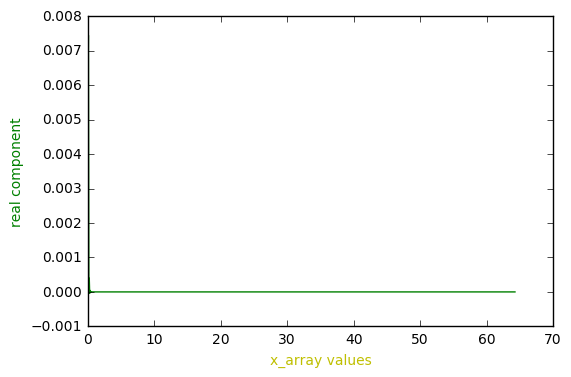

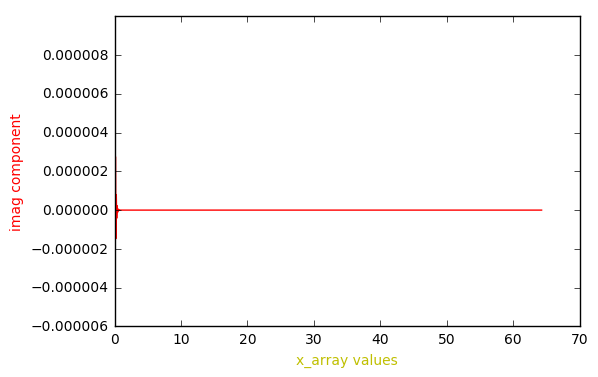

In [13]:
# куда девается индикатор? У нас просто нет ни одной точки, где x было бы отрицательным, в этой постановке. 
# Появится - допишу, примеров есть много уже, благо.

def F_minus_capital():
    big_integral = fft.ifft(integrand_minus(u_space))
    exponent = exp(-x_space * omega_plus)
    return 1/(2*pi) * M * du * big_integral * exponent

fm = F_minus_capital()
               
plt.plot(x_space, fm.real, 'g')
plt.xlabel('x_array values', color='y')
plt.ylabel('real component', color='g')
plt.show()

plt.plot(x_space, fm.imag, 'r')
plt.xlabel('x_array values', color='y')

plt.ylabel('imag component', color='r')
plt.show()

#Теперь нас интересует $$ \hat{F}^-(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^-(x) dx $$

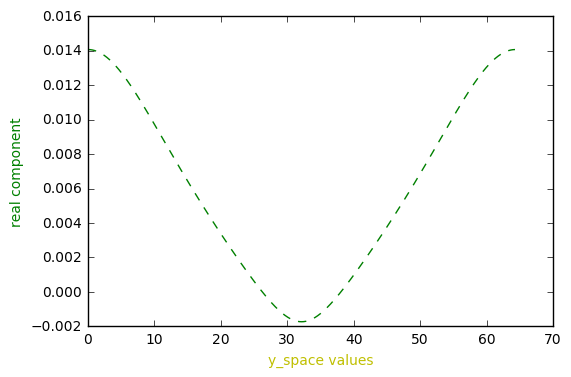

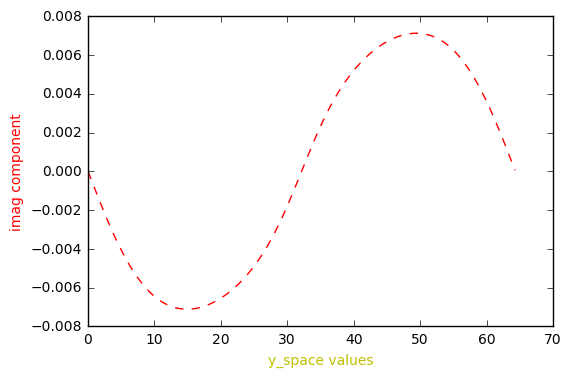

In [18]:
# Заметим, что входным аргументом здесь будет вовсе не кси, а x, на которых считается подынтегральная функция

def F_minus_capital_hat():
    return fft.fft(F_minus_capital())

plt.plot(x_space, F_minus_capital_hat().real, 'g--')
plt.xlabel('y_space values', color='y')
plt.ylabel('real component', color='g')
plt.show()

plt.plot(x_space, F_minus_capital_hat().imag, 'r--')
plt.xlabel('y_space values', color='y')
plt.ylabel('imag component', color='r')
plt.show()

Наконец, у нас достаточно функций, чтобы закодировать 
$$ \phi^-_q(\xi) = exp[-i\xi F^-(0) - \xi^2 \hat{F}^-(\xi)] $$

Но прежде стоит заметить, что нам удобнее, из практических соображений, вычислять $\phi^-_q(\xi)$ сразу в виде массива. Тогда нам нужно некоторым специальным образом обработать часть $ -i\xi F^-(0)$

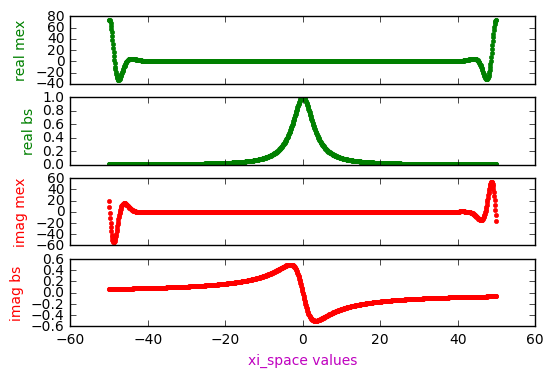

In [22]:
def make_phi_minus_array(xi_array):
    first_term = - 1j * u_space * F_minus_capital()[0]
    second_term = - u_space * u_space * F_minus_capital_hat()
    return exp(first_term + second_term)

def make_cf_bs_phi_minus_array(xi_array):
    beta_minus = - (gamma + sqrt(gamma**2 + 2*sigma**2 * q))/sigma**2
    phi_minus_array = array([-beta_minus/(-beta_minus + 1j*2*pi*xi) for xi in xi_array])
    return phi_minus_array

ax1 = plt.subplot(411)
plt.plot(u_space, (make_phi_minus_array(u_space)).real, 'g.')
plt.ylabel('real mex', color='g')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(412, sharex=ax1)
plt.plot(u_space, make_cf_bs_phi_minus_array(u_space).real, 'g.')
plt.ylabel('real bs', color='g')
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(u_space, (make_phi_minus_array(u_space)).imag, 'r.')
plt.ylabel('imag mex', color='r')
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = plt.subplot(414, sharex=ax1)
plt.plot(u_space, make_cf_bs_phi_minus_array(u_space).imag, 'r.')
plt.ylabel('imag bs', color='r')

plt.xlabel('xi_space values', color='m')

filename_real_pic = "symbol_phi_minus_bs_mex N %2d L %.1f M %2d.png"  % (N, L, M)
plt.savefig("out_pictures/" + filename_real_pic)
plt.show()

plt.show()

## Фи-плюс

$\phi^+_q(\xi)$ будут иметь вид:

$$ \phi^+_q(\xi) = exp[i\xi F^+(0) - \xi^2 \hat{F}^+(\xi)], $$
$$ F^+(x) = 1_{(-\infty, 0]}(x)(2\pi)^{-1} \int_{-\infty + i\omega_-}^{+\infty + i\omega_-} e^{ix\eta} \frac{ln(q+\psi(\eta))}{\eta^2} d\eta = $$
$$ = 1_{(-\infty, 0]}(x)(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix(\upsilon+i\omega_-)} \frac{ln(q+\psi(\upsilon+i\omega_-))}{(\upsilon+i\omega_-)^2} d(\upsilon) = $$ 
$$ = 1_{(-\infty, 0]}(x)e^{-x\omega_-}\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} \frac{ln(q+\psi(\upsilon+i\omega_-))}{(\upsilon+i\omega_-)^2} d(\upsilon);$$
$$ \hat{F}^+(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^+(x) dx. $$

In [ ]:
# преобразование Фурье должно допускать вычисление интеграла c \xi
# но поскольку мы имеем дело с ПДО, нужно ещё знать, с какими именно
xi_space = fft.fftfreq(M, d=d)
upsilon_space = fft.fftfreq(M, d=d)

omega_minus = -1

# Теперь надо поколдовать с функцией F(x). Кодировать её для каждого отдельного значения x можно, 
# но для этого придётся использовать медленные методы вычисления интегралов.
# Поэтому она должна принимать  массив длиной M и обрабатывать его.

Вычислим значение подынтегральной части сразу в виде массива: $$intfunc(\upsilon) = \frac{ln(q+\psi(\upsilon+i\omega_-))}{(\upsilon+i\omega_-)^2}, \upsilon \in \upsilon\_space$$

In [ ]:
def integrand_plus(upsilon_array):
    """
    принимает и возвращает массив длиной M,
    работает (должна) на upsilon_space по умолчанию
    тоже должна возвращать
    """
    return np.array([log(q + psi(upsilon + 1j*omega_minus)) / (upsilon + 1j*omega_minus)**2 for upsilon in upsilon_array])

# print(integrand_minus(upsilon_space))
# plt.plot(upsilon_space, integrand_plus(upsilon_space).real, 'g.')
# plt.xlabel('upsilon values', color='m')
# plt.ylabel('real component', color='g')
# plt.show()

# plt.plot(upsilon_space, integrand_plus(upsilon_space).imag, 'r.')
# plt.xlabel('xi_space values', color='m')
# plt.ylabel('imag component', color='r')
# plt.show()

Теперь реализуем кусок в виде fft:
$$ F^+(x) = 1_{(-\infty, 0]}(x)e^{-x\omega_-}\color{magenta}{\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} intfunc(\upsilon) d(\upsilon)} $$

In [ ]:
# factor functions
def F_plus_capital(x_array):
    big_integral = fft.ifft(integrand_plus(upsilon_space))
    osc_exponent = [exp(-1 * x_elem * omega_minus) for x_elem in x_array] 
    weighted_big_integral = np.array(osc_exponent) * np.array(big_integral)
    indicator_array = np.where(np.array(x_array) <= 0, 1,0)
    return indicator_array * weighted_big_integral

# print(F_plus_capital(y_space))
# plt.plot(y_space, F_plus_capital(y_space).real, 'g.')
# plt.xlabel('y_space values', color='y')
# plt.ylabel('real component', color='g')
# plt.show()

# plt.plot(y_space, F_plus_capital(y_space).imag, 'r.')
# plt.xlabel('y_space values', color='y')
# plt.ylabel('imag component', color='r')
# plt.show()

Теперь нас интересует $$ \hat{F}^+(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^+(x) dx $$

In [ ]:
def F_plus_capital_hat(xi_array):
    return fft.fft(F_plus_capital(y_space))

# plt.plot(xi_space, F_plus_capital_hat(xi_space).real, 'g.')
# plt.xlabel('xi_space values', color='m')
# plt.ylabel('imag component', color='r')
# plt.show()

# plt.plot(xi_space, F_plus_capital_hat(xi_space).imag, 'r.')
# plt.xlabel('xi_space values', color='m')
# plt.ylabel('imag component', color='r')
# plt.show()

Наконец, у нас достаточно функций, чтобы закодировать 
$$ \phi^+_q(\xi) = exp[i\xi F^+(0) - \xi^2 \hat{F}^+(\xi)] $$

Но прежде стоит заметить, что нам удобнее, из практических соображений, вычислять $\phi^+_q(\xi)$ сразу в виде массива. Тогда нам нужно некоторым специальным образом обработать часть $ -i\xi F^+(0)$


In [ ]:
def make_phi_plus_array(xi_array):
    first_term = 1j *  np.array(xi_array) * F_plus_capital(np.zeros(len(y_space)))
    second_term = - np.array(xi_array) * np.array(xi_array) * F_plus_capital_hat(xi_array)
    return exp(first_term + second_term)

def make_cf_bs_phi_plus_array(xi_array):
    beta_plus = - (gamma - sqrt(gamma**2 + 2*sigma**2 * q))/sigma**2
    print(beta_plus)
    phi_plus_array = array([beta_plus/(beta_plus - 1j*2*pi*xi) for xi in xi_array])
    return phi_plus_array

ax1 = plt.subplot(411)
plt.plot(xi_space, (make_phi_plus_array(xi_space)).real, 'g.')
plt.ylabel('real mex', color='g')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(412, sharex=ax1)
plt.plot(xi_space, make_cf_bs_phi_plus_array(xi_space).real, 'g.')
plt.ylabel('real bs', color='g')
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(xi_space, (make_phi_plus_array(xi_space)).imag, 'r.')
plt.ylabel('imag mex', color='r')
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = plt.subplot(414, sharex=ax1)
plt.plot(xi_space, make_cf_bs_phi_plus_array(xi_space).imag, 'r.')
plt.ylabel('imag bs', color='r')

plt.xlabel('xi_space values', color='m')

filename_real_pic = "symbol_phi_plus_bs_mex N %2d L %.1f M %2d.png"  % (N, L, M)
plt.savefig("out_pictures/" + filename_real_pic)
plt.show()

plt.show()